In [72]:
#!pip install keras-unet

In [1]:
import os
import cv2
import time
import shutil
import random
import inspect
#import imageio as im
import numpy as np
import mahotas as mh
from PIL import Image
from tabulate import tabulate
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
#from skimage import measure, filters

RuntimeError: module compiled against API version 0xf but this version of numpy is 0xd

Could not import submodules (exact error was: numpy.core.multiarray failed to import).

There are many reasons for this error the most common one is that you have
either not built the packages or have built (using `python setup.py build`) or
installed them (using `python setup.py install`) and then proceeded to test
mahotas-imread **without changing the current directory**.

Try installing and then changing to another directory before importing mahotas.



RuntimeError: module compiled against API version 0xf but this version of numpy is 0xd

In [2]:
# original directory path and working directory path for images
data = "/raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/raw_files"
working_dir = "/raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir"
######################################################################################################
experiment = "test3" 
######################################################################################################
real = f"{working_dir}/{experiment}/real_images"
#########################################################################################################

directories = {
    "normalized": f"{working_dir}/{experiment}/normalized_images",
    "cropped": f"{working_dir}/{experiment}/cropped_images",
    "npy": f"{working_dir}/{experiment}/pre_processing/npy",
    "originals": f"{working_dir}/{experiment}/pre_processing/originals",
    "masks": f"{working_dir}/{experiment}/pre_processing/masks",
    "test": f"{working_dir}/{experiment}/pre_processing/test",
    "s": f"{working_dir}/{experiment}/S",
    "crop_original": f"{working_dir}/{experiment}/pre_processing/crop_originals",
    "crop_masks": f"{working_dir}/{experiment}/pre_processing/crop_masks",
    "op": f"{working_dir}/{experiment}/post_processing/original_prediction",
    "pp": f"{working_dir}/{experiment}/post_processing/processed_prediction"
    
}

In [3]:
npy = f"{working_dir}/{experiment}/pre_processing/npy1"
machine = f"{working_dir}/{experiment}/pre_processing/machine"

In [4]:
import keras
from keras_unet.models import custom_unet

2023-04-10 09:51:26.291204: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [5]:
imagedata = np.load(os.path.join(npy, 'original.npz'))
labeldata = np.load(os.path.join(npy, 'mask.npz'))

In [6]:
images_file = imagedata['data']
images_name = imagedata['names']

In [7]:
len (images_name)


1812

In [8]:
labels_file = labeldata['data']
labels_name = labeldata['names']


#labels_file = os.path.join(npy, 'mask.npy')
#test_files = os.path.join(npy, 'test.npy')

In [9]:
images = images_file
labels = labels_file
#test = np.load(test_file)

In [10]:
images.shape

(1812, 512, 512)

In [11]:
labels.shape

(1812, 512, 512)

In [12]:
 # full dataset does not have the last channel
#images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
#labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)
#test = test.reshape(test.shape[0],test.shape[1],test.shape[2],1)

In [13]:
images.shape

(1812, 512, 512)

In [14]:
labels.shape

(1812, 512, 512)

In [15]:
p = np.random.permutation(len(images))

In [16]:
images = images[p]
labels = labels[p]
#test = test[p]

In [17]:
labels = labels.astype(np.float64)

In [18]:
images = images.astype(np.float64)
for i in range(images.shape[0]):
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually


In [19]:
# # Calculate the indices for the splits
# num_images = len(images)
# num_labels = len(labels)
# train_x = int(num_images * 0.6)
# train_y = int(num_labels * 0.6)
# val_x = int(num_images * 0.85)
# val_y = int(num_labels * 0.85)

In [20]:
# X_train = images[:train_x]
# y_train = labels[:train_y]
# X_val = images[train_x:val_x]
# y_val = labels[train_y:val_y]
# X_test = images[val_x:]
# y_test = labels[val_y:]

#X_test = test[80:]
#y_test = test[80:]

In [21]:
X_train = images[0:1200]
y_train = labels[0:1200]
X_val = images[1201:1700]
y_val = labels[1201:1700]
X_test = images[0:1812]
y_test = labels[0:1812]

In [22]:
y_train.shape

(1200, 512, 512)

In [23]:
###################   LOADING MODEL   ######################

In [ ]:
def create_model():
    from keras.models import Sequential
    from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
    from keras.metrics import MeanIoU

    n_classes = 1 # number of classes in your segmentation masks
    IoU = MeanIoU(num_classes=n_classes)

    model = Sequential()
    # Encoder
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(512, 512)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

    # Decoder
    model.add(Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same'))
    model.add(Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same'))

In [96]:
opt = keras.optimizer_v1.Adam(lr=0.01)

In [97]:


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[IoU])

In [98]:
########### IMPORTS #############

In [99]:
from keras import regularizers
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras_unet.utils import plot_segm_history, plot_imgs
from skimage import measure

import skimage.filters as filters
import skimage.measure as measure
from sklearn.metrics import classification_report
import keras.optimizers
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

In [100]:
########################   FUNCTIONS ######################

In [101]:
def labels(binary_mask):
    # Calculate number_1
    labeled, num = mh.label(binary_mask)
    print("Number_1:", num)

    # Calculate region sizes
    region_sizes = measure.regionprops(labeled, intensity_image=binary_mask)
    sizes = [region.area for region in region_sizes]

    # Find min_region_size
    sizes.sort()
    large_region_start_index = next((i for i in range(1,len(sizes)) if sizes[i] - sizes[i-1] < numbi), len(sizes))
    #large_region_start_index = next((i for i in range(1,len(sizes)) if sizes[i] - sizes[i-1] > 100), len(sizes))
    min_region_size = (sizes[large_region_start_index-1] + sizes[large_region_start_index]) // 2
    print("Min_region_size:", min_region_size)
    #print ('sizes:',sizes)
    a = len(sizes)
    print ('length of sizes =',a)

    # Calculate large_regions
    num_large_regions = 0
    for region in region_sizes:
        if region.area > min_region_size:
            num_large_regions += 1
    print("Large_regions:", num_large_regions)

    # Calculate threshold
    thresh = filters.threshold_otsu(binary_mask)
    #print(labels_name[jk])
    print("Threshold:", thresh)

In [102]:
def pros(binary_mask):
    import matplotlib.pyplot as plt
    from io import StringIO
    import sys
    # ...

    fig, axs = plt.subplots(1, 5, figsize=(15, 5))

    # Operation 1
    labeled, number = mh.label(binary_mask)
    sizes = mh.labeled.labeled_size(labeled)
    numbi = int(np.average(sizes))
    large_region_start_index = next((i for i in range(1,len(sizes)) if sizes[i] - sizes[i-1] < numbi), len(sizes))
    min_region_size = (sizes[large_region_start_index-1] + sizes[large_region_start_index]) // 2
    too_small = np.where(sizes < min_region_size)
    labeled_only_big = mh.labeled.remove_regions(labeled, too_small)
    axs[0].imshow(labeled)
    #axs[0].imshow(labeled_only_big)
    axs[0].set_title('Operation 1')

    # Capture the output of the labels function
    old_stdout = sys.stdout
    sys.stdout = mystdout = StringIO()

    labels(labeled_only_big)

    # Restore stdout
    sys.stdout = old_stdout

    # Display the captured output as text below the subplot
    axs[0].text(0.5, -0.1, mystdout.getvalue(), ha='center', va='top', transform=axs[0].transAxes)

    # Operation 2
    binary_mask = labeled_only_big.copy()
    binary_mask[binary_mask > 0] = 1

    axs[1].imshow(binary_mask)
    axs[1].set_title('Operation 2')

    # Capture the output of the labels function
    old_stdout = sys.stdout
    sys.stdout = mystdout = StringIO()

    labels(binary_mask)

    # Restore stdout
    sys.stdout = old_stdout

    # Display the captured output as text below the subplot
    axs[1].text(0.5, -0.1, mystdout.getvalue(), ha='center', va='top', transform=axs[1].transAxes)

    # Operation 3
    binary_mask_closed = mh.gaussian_filter(binary_mask, sigma=5)

    axs[2].imshow(binary_mask_closed)
    axs[2].set_title('Operation 3')

    # Capture the output of the labels function
    old_stdout = sys.stdout
    sys.stdout = mystdout = StringIO()

    labels(binary_mask_closed)

    # Restore stdout
    sys.stdout = old_stdout

    # Display the captured output as text below the subplot
    axs[2].text(0.5, -0.1, mystdout.getvalue(), ha='center', va='top', transform=axs[2].transAxes)

    # Operation 4
    binary_mask= binary_mask.reshape(binary_mask.shape[0],binary_mask.shape[1])
    binary_mask_open = mh.morph.close_holes(binary_mask)

    #axs[3].imshow(binary_mask_open)
    axs[3].set_title('Operation 4')

    # Capture the output of the labels function
    old_stdout = sys.stdout
    sys.stdout = mystdout = StringIO()

    labels(binary_mask_open)

    # Restore stdout
    sys.stdout = old_stdout

    # Display the captured output as text below the subplot
    axs[3].text(0.5, -0.1, mystdout.getvalue(), ha='center', va='top', transform=axs[3].transAxes)

    # Operation 5
    for i in range(3):
        binary_mask_dialate = mh.morph.dilate(binary_mask_open)

    axs[4].imshow(binary_mask_dialate)
    axs[4].set_title('Operation 5')

    # Capture the output of the labels function
    old_stdout = sys.stdout
    sys.stdout = mystdout = StringIO()

    labels(binary_mask_dialate)

    # Restore stdout
    sys.stdout = old_stdout

    # Display the captured output as text below the subplot
    axs[4].text(0.5, -0.1, mystdout.getvalue(), ha='center', va='top', transform=axs[4].transAxes)

    plt.show()

In [103]:
def readpaths(directories):
    for key, path in directories.items():
        globals()[key] = path

In [104]:
readpaths(directories)

In [105]:
len(y_train)

1200

In [106]:
jk = 1187

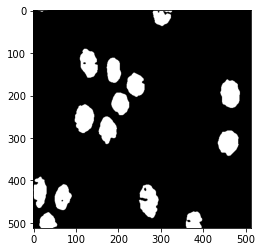

In [107]:
binary_mask = y_train[jk].squeeze()
# Plot the binary mask
plt.imshow(binary_mask, cmap='gray')
plt.show()

In [108]:
labeled, number = mh.label(binary_mask)
sizes = mh.labeled.labeled_size(labeled)
# large_region_start_index = next((i for i in range(1,len(sizes)) if sizes[i] - sizes[i-1]), len(sizes))
# min_region_size = (sizes[large_region_start_index-1] + sizes[large_region_start_index]) // 2
# too_small = np.where(sizes < min_region_size)
# labeled_only_big = mh.labeled.remove_regions(labeled, too_small)
# axs[0].imshow(labeled)

In [109]:
sizes.max()

237080

In [110]:
sizes.min()

47

In [140]:
binary_mask.shape

(512, 512, 1)

In [111]:
np.average(sizes)

16384.0

In [112]:
print(sizes)

[237080     47   1212   2036   1560   1763   2352   1648   2294   1867
   2166   1655   1681   2452   1197   1134]


In [113]:
max_index = np.argmax(sizes)

In [114]:
# Remove maximum value
sizes = np.delete(sizes, max_index)

In [115]:
sizes.max()

2452

In [116]:
sizes.min()

47

In [117]:
a = int(np.average(sizes))
print (a)

1670


In [118]:
print(sizes)

[  47 1212 2036 1560 1763 2352 1648 2294 1867 2166 1655 1681 2452 1197
 1134]


In [119]:
numbi = int(np.average(sizes))
large_region_start_index = next((i for i in range(1, len(sizes)) if (sizes[i] - sizes[i-1]) < numbi), len(sizes))
min_region_size = (sizes[large_region_start_index-1] + sizes[large_region_start_index]) // 2
print (min_region_size)

629


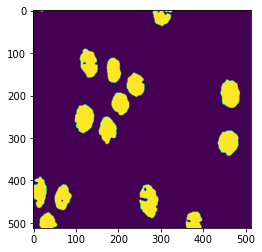

In [120]:
plt.imshow(binary_mask)

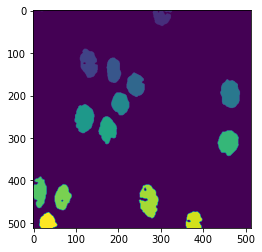

In [121]:
labeled, number = mh.label(binary_mask)

plt.imshow(labeled)

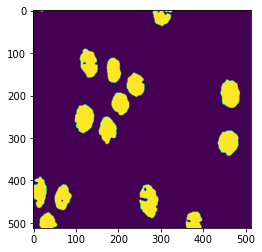

In [122]:
binary_mask = labeled.copy()
binary_mask[binary_mask > 0] = 1
   
plt.imshow(binary_mask)

In [123]:
region_sizes = measure.regionprops(binary_mask, intensity_image=binary_mask)
print(region_sizes)

In [124]:

labeled, number = mh.label(binary_mask)
sizes = mh.labeled.labeled_size(labeled)
#sizes = np.array([region.area for region in region_sizes], dtype=np.int64)
numbi = int(np.average(sizes))
#print(sizes)

# large_region_start_index = next((i for i in range(1,len(sizes)) if sizes[i] - sizes[i-1] < numbi), len(sizes))
# print(large_region_start_index)
# min_region_size = (sizes[large_region_start_index-1] + sizes[large_region_start_index]) // 2
# print(min_region_size)


In [125]:
sizes

array([237080,     47,   1212,   2036,   1560,   1763,   2352,   1648,
         2294,   1867,   2166,   1655,   1681,   2452,   1197,   1134],
      dtype=uint32)

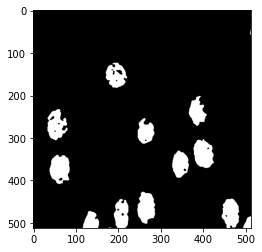

Number_1: 14
Min_region_size: 183
Large_regions: 12
000000_000000_000297_000000_1_2.tif
Threshold: 0.001953125

000000_000000_000297_000000_1_2.tif


In [126]:
import mahotas as mh
from skimage import measure, filters
import matplotlib.pyplot as plt
jk = 87
# Select a single binary mask from y_train
binary_mask = y_train[jk].squeeze()

# Plot the binary mask
plt.imshow(binary_mask, cmap='gray')
plt.show()

# Calculate number_1
labeled, num = mh.label(binary_mask)
print("Number_1:", num)

# Calculate region sizes
region_sizes = measure.regionprops(labeled, intensity_image=binary_mask)
sizes = [region.area for region in region_sizes]

# Find min_region_size
sizes.sort()
large_region_start_index = next((i for i in range(1,len(sizes)) if sizes[i] - sizes[i-1] > 100), len(sizes))
min_region_size = (sizes[large_region_start_index-1] + sizes[large_region_start_index]) // 2
print("Min_region_size:", min_region_size)

# Calculate large_regions
num_large_regions = 0
for region in region_sizes:
    if region.area > min_region_size:
        num_large_regions += 1
print("Large_regions:", num_large_regions)

# Calculate threshold
thresh = filters.threshold_otsu(binary_mask)
print(labels_name[jk])
print("Threshold:", thresh)
print()
print(labels_name[jk])

In [127]:
print(sizes)
len(sizes)

[6, 16, 350, 1097, 1618, 1721, 1806, 1815, 1932, 2149, 2196, 2316, 2431, 2441]


14

In [128]:
labeled, number = mh.label(binary_mask)
sizes = mh.labeled.labeled_size(labeled)
print (sizes)
len(sizes)
too_small = np.where(sizes < min_region_size)
labeled_only_big = mh.labeled.remove_regions(labeled, too_small)

[240250     16   1932   1721   2196   1618   2431   1815   2441   2316
   2149   1806   1097    350      6]


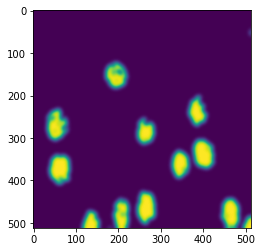

In [129]:
binary_mask_closed = mh.gaussian_filter(binary_mask, sigma=5)

plt.imshow(binary_mask_closed)

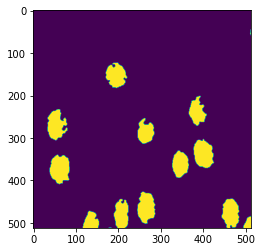

In [130]:
binary_mask_open=mh.morph.close_holes(binary_mask)
plt.imshow(binary_mask_open)

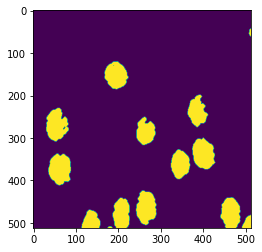

In [131]:
for i in range(3):
    binary_mask_open = mh.morph.dilate(binary_mask_open)
    plt.imshow(binary_mask_open)

In [132]:
experiment = "test3" 
working_dir = "/raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir"
pp =f"{working_dir}/{experiment}/post_processing/processed_prediction"
op = f"{working_dir}/{experiment}/post_processing/original_prediction"
crop_original =  f"{working_dir}/{experiment}/pre_processing/crop_originals"
crop_masks = f"{working_dir}/{experiment}/pre_processing/crop_masks"

In [133]:
from keras import regularizers
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras_unet.utils import plot_segm_history, plot_imgs
from skimage import measure

import skimage.filters as filters
import skimage.measure as measure
from sklearn.metrics import classification_report
import keras.optimizers
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

In [134]:
import mahotas as mh

In [135]:
import numpy as np

In [ ]:
import cv2
from PIL import Image

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train,
                    y_train,
                    batch_size=60,
                    epochs=5,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])
# Make predictions and apply thresholding
y_pred = model.predict(X_test)

# Apply contrast stretching to the predicted images
new_min_value = 0
new_max_value = 255


for i in range(10):#for i in range(y_pred.shape[0])
    z = images_name[i]
    binary_mask = y_pred[i]
    binary_mask.shape    
    print(binary_mask.shape)
    sizes_b = mh.labeled.labeled_size(binary_mask)
    labeled, number = mh.label(binary_mask)
    sizes_l = mh.labeled.labeled_size(labeled)
    
    #binary_mask= binary_mask.reshape(binary_mask.shape[0],binary_mask.shape[1])
    plt.imshow(binary_mask')
    plt.show()
    print(binary_mask.shape)
    print("Sizes for image", sizes_b)
    plt.imshow(labeled)
    plt.show()
    print(labeled.shape)
    print("Sizes for image", sizes_l)
#     save_path = os.path.join(op, z)
#     print("Saving image to:", save_path)    
#     mh.imsave(save_path, binary_mask)

Epoch 1/5
20/20 [==============================] - 11s 566ms/step - loss: 0.1885 - mean_io_u_1: 0.4444 - val_loss: 0.1880 - val_mean_io_u_1: 0.4441
Epoch 2/5
20/20 [==============================] - 11s 536ms/step - loss: 0.1802 - mean_io_u_1: 0.4444 - val_loss: 0.1845 - val_mean_io_u_1: 0.4441
Epoch 3/5
20/20 [==============================] - 11s 536ms/step - loss: 0.1710 - mean_io_u_1: 0.4444 - val_loss: 0.1769 - val_mean_io_u_1: 0.4441
Epoch 4/5
20/20 [==============================] - 11s 538ms/step - loss: 0.1767 - mean_io_u_1: 0.4444 - val_loss: 0.2113 - val_mean_io_u_1: 0.4441
Epoch 5/5
20/20 [==============================] - 11s 535ms/step - loss: 0.1763 - mean_io_u_1: 0.4444 - val_loss: 0.1758 - val_mean_io_u_1: 0.4441
(512, 512, 1)


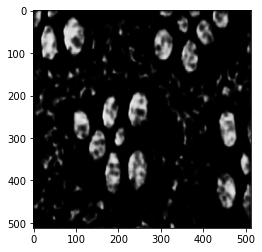

Saving image to: /raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/test3/post_processing/original_prediction/000000_000000_000432_000000_0_2.tif


TypeError: Cannot handle this data type: (1, 1, 1), <f4

In [141]:
import cv2
from PIL import Image

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train,
                    y_train,
                    batch_size=60,
                    epochs=5,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

# Make predictions and apply thresholding
y_pred = model.predict(X_test)
#y_pred = (y_pred > 0.55).astype(np.uint8)

# Calculate precision, recall, and F1 score
#report = classification_report(y_test.flatten(), y_pred.flatten(), target_names=['background', 'circle'], output_dict=True)
#print('Classification report:\n', report)

# Apply contrast stretching to the predicted images
new_min_value = 0
new_max_value = 255

for i in range(5):#for i in range(y_pred.shape[0])
#     plt.imshow(y_pred[i], cmap='gray')
#     plt.show()
    z = images_name[i]
#     image = Image.fromarray((y_pred[i].squeeze() * 255).astype(np.uint8))
#     min_value, max_value = image.getextrema()
#     if max_value != min_value:
#         scale = (new_max_value - new_min_value) / (max_value - min_value)
#         image = image.point(lambda i: (i - min_value) * scale + new_min_value)
#     y_pred[i] = np.expand_dims(np.array(image), axis=-1) / 255
#     print(z)
    binary_mask = y_pred[i]
    binary_mask.shape    
    print(binary_mask.shape)
    #binary_mask= binary_mask.reshape(binary_mask.shape[0],binary_mask.shape[1])
    plt.imshow(binary_mask, cmap='gray')
    plt.show()
#     save_path = os.path.join(op, z)
#     print("Saving image to:", save_path)    
#     mh.imsave(save_path, binary_mask)



    #processing(binary_mask)
    #pros(binary_mask)
        # Plotting results
    from keras_unet.utils import plot_segm_history
    #shutil.copy(os.path.join(crop_original, z), os.path.join(op, z))
#     binary_mask.shape    
#     print(binary_mask.shape)
#     binary_mask = (binary_mask * 255).astype(np.uint8) # convert to bool data type
#     print()
#     print()
#     print('unit8 converted')
# #     plt.imshow(binary_mask, cmap='gray')
#     plt.show()
    save_path = os.path.join(op, z)
    print("Saving image to:", save_path)    
    mh.imsave(save_path, binary_mask)


#     print ('################################')
#     print()
#     print()
#     from mahotas import imread
#     import matplotlib.pyplot as plt
#     print(save_path)
#     print(z)
    # read the image from the file path
#     saved_image = imread(save_path)

#     # display the image
#     plt.imshow(saved_image, cmap='gray')
#     plt.show()
#     print ('################################')
    
    
#     save_path = os.path.join(op, z)
#     print("Saving image to:", save_path)
#     mh.imsave(os.path.join(op,z),binary_mask)
          
    
    
    
# print(z)
# binary_mask = y_pred[i]
# plt.imshow(binary_mask, cmap='gray')
# plt.show()
# #processing(binary_mask)


In [ ]:
def findings(a):
    for i in range(a):
        import os
        import random
        import cv2
        import mahotas as mh

        import numpy as np


        file_list = sorted(os.listdir(op))
        z = random.choice([f for f in file_list if f.endswith("tif")])
        img = mh.imread(os.path.join(op, z))
        print(z)
        fig.set_size_inches(30, 30)
        plt.imshow(img)
        image = (img * 255).astype('uint8')
        ########################################
        dst = cv2.fastNlMeansDenoising(img, None,60, 40, 40)
        #(SOURCE, NEW IMAGE, FILTER STRENGTH MAX -, SIZE OF WINDOW FOR PIXEL SEARCH, TO AVERAGE PIXELS)
        # Display the original image and the denoised image
        plt.subplot(121), plt.imshow(img)
        plt.subplot(122), plt.imshow(dst)
        plt.show()
        ###################################################
        # Check if image is grayscale
        if len(img.shape) == 2:
            gray = img
        else:
            # Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Apply binary threshold with a threshold value of 150
        _, binary_mask = cv2.threshold(gray, 100
                                  , 255, cv2.THRESH_BINARY)

        # Display the original image and the thresholded image side by side
        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[0].set_title('Original Image')
        axs[1].imshow(binary_mask, cmap='gray')
        axs[1].set_title('Thresholded Image')
        plt.show()
        ########################################
        pros(binary_mask)
        

Epoch 1/5
20/20 [==============================] - 11s 574ms/step - loss: 0.1487 - mean_io_u_1: 0.4444 - val_loss: 0.1672 - val_mean_io_u_1: 0.4441
Epoch 2/5
20/20 [==============================] - 11s 534ms/step - loss: 0.1498 - mean_io_u_1: 0.4444 - val_loss: 0.1506 - val_mean_io_u_1: 0.4441
Epoch 3/5
20/20 [==============================] - 11s 533ms/step - loss: 0.1462 - mean_io_u_1: 0.4444 - val_loss: 0.1444 - val_mean_io_u_1: 0.4441
Epoch 4/5
20/20 [==============================] - 11s 533ms/step - loss: 0.1407 - mean_io_u_1: 0.4444 - val_loss: 0.1476 - val_mean_io_u_1: 0.4441
Epoch 5/5
20/20 [==============================] - 11s 534ms/step - loss: 0.1429 - mean_io_u_1: 0.4444 - val_loss: 0.1451 - val_mean_io_u_1: 0.4441


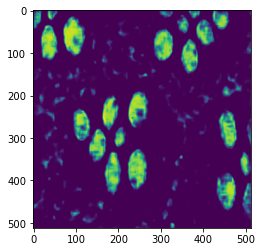

[262144]


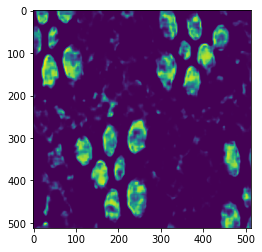

[262144]


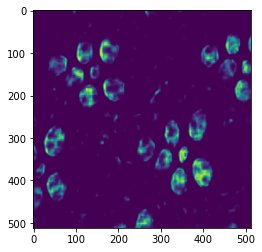

[262144]


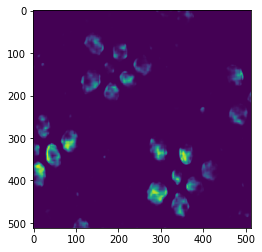

[262144]


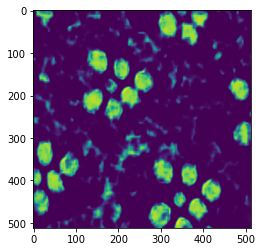

[262144]


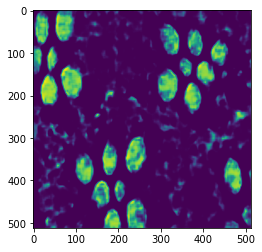

[262144]


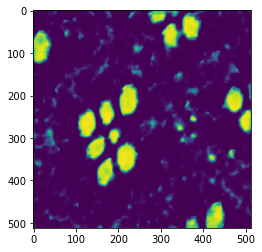

[262144]


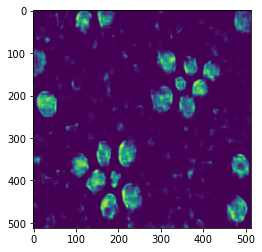

[262144]


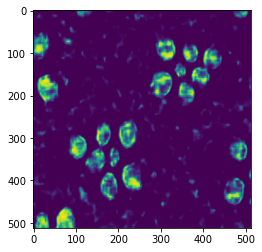

[262144]


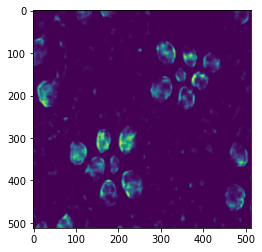

[262144]


In [145]:
import cv2
from PIL import Image
import numpy as np
import mahotas as mh
import matplotlib.pyplot as plt

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train,
                    y_train,
                    batch_size=60,
                    epochs=5,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

# Make predictions and apply thresholding
y_pred = model.predict(X_test)

# Apply contrast stretching to the predicted images
new_min_value = 0
new_max_value = 255

# Loop through the first 10 predicted images
for i in range(10):
    # Get the name of the i-th image
    image_name = images_name[i]
    
    # Get the i-th binary mask
    binary_mask = y_pred[i]
    sizes_b = mh.labeled.labeled_size(binary_mask)
    plt.imshow(binary_mask)
    plt.show()
    print(sizes_b)
    
    # Get the sizes of the i-th binary mask and labeled image
    sizes_b = mh.labeled.labeled_size(binary_mask)
    labeled, number = mh.label(binary_mask)
    sizes_l = mh.labeled.labeled_size(labeled)
    
    # Reshape the binary mask if necessary
    if len(binary_mask.shape) == 3:
        binary_mask1 = binary_mask.squeeze()
        
    if len(labeled.shape) == 3:
        labeled1 = labeled.squeeze() 


        
        
    
#     sizes_b1 = mh.labeled.labeled_size(binary_mask)
#     sizes_l1 = mh.labeled.labeled_size(labeled)
#     # Plot the binary mask and labeled image
#     fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
#     ax1.imshow(binary_mask)
#     ax1.set_title('Binary mask')
#     ax2.imshow(labeled)
#     ax2.set_title('Labeled image')
#     plt.suptitle(f"Image name: {image_name}\nBinary mask sizes: {sizes_b}\nLabeled image sizes: {sizes_l}")
#     plt.show()

#     fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(10,5))
#     ax3.imshow(binary_mask1)
#     ax3.set_title('Binary mask squeeze')
#     ax4.imshow(labeled1)
#     ax4.set_title('Labeled image squeeze')
#     plt.suptitle(f"Image name: {image_name}\nBinary mask sizes: {sizes_b1}\nLabeled image sizes: {sizes_l1}")
#     plt.show()

In [66]:
# Define threshold values to use
thres = [0.20,0.25, 0.30, 0.35]
for thres in thres:
    # Make predictions and apply thresholding
    #y_pred = model.predict(X_test)
    # Make predictions and apply thresholding
    y_pred = model.predict(X_test)
    y_pred = (y_pred > thres).astype(np.uint8)
    new_min_value = 0
    new_max_value = 255
    # Create a figure with three columns
    fig, axes = plt.subplots(nrows=y_pred.shape[0], ncols=4, figsize=(15, 20))
     # Loop through predictions and plot thresholded images
    for i in range(y_pred.shape[0]):
        z = images_name[i]
        binary_mask = y_pred[i]
        image = Image.fromarray((binary_mask.squeeze() * 255).astype(np.uint8))
        min_value, max_value = image.getextrema()
        scale = (new_max_value - new_min_value) / (max_value - min_value)
        image = image.point(lambda i: (i - min_value) * scale + new_min_value)
        y_pred[i] = np.expand_dims(np.array(image), axis=-1) / 255
        binary_mask = y_pred[i]
        # Plot image with current threshold value in appropriate column
        if threshold == 0.20:
            axes[i, 2].imshow(binary_mask, cmap='gray')
            axes[i, 2].set_title(z)
        elif threshold == 0.25:
            axes[i, 0].imshow(binary_mask, cmap='gray')
            axes[i, 0].set_title(z)
        elif threshold == 0.30:
            axes[i, 1].imshow(binary_mask, cmap='gray')
            axes[i, 1].set_title(z)
        elif threshold == 0.35:
            axes[i, 2].imshow(binary_mask, cmap='gray')
            axes[i, 2].set_title(z)

    plt.show()
#This code will iterate through the thresholds list and for each threshold value, it will make predictions using the trained model and apply thresholding using the current threshold value. Then, it will plot the resulting images in three columns, with each column corresponding to a different threshold value.






#         binary_mask = y_pred[i]
#         plt.imshow(binary_mask, cmap='gray')
#         plt.show()   
#         binary_mask, number = mh.label(binary_mask)
#         plt.imshow(binary_mask, cmap='gray')
#         plt.show() 
#         labels(binary_mask)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fd71aee0940> (for post_execute):


KeyboardInterrupt: 

In [ ]:
    for i in range(y_pred.shape[0]):
        z = images_name[i]
        binary_mask = y_pred[i]
        image = Image.fromarray((binary_mask.squeeze() * 255).astype(np.uint8))
        min_value, max_value = image.getextrema()
        scale = (new_max_value - new_min_value) / (max_value - min_value)
        image = image.point(lambda i: (i - min_value) * scale + new_min_value)
        y_pred[i] = np.expand_dims(np.array(image), axis=-1) / 255
        binary_mask = y_pred[i]       
        binary_mask, number = mh.label(binary_mask)
        labels(binary_mask)
        Plot image with current threshold value in appropriate column
        elif threshold == 0.20:
            axes[i, 2].imshow(binary_mask, cmap='gray')
            axes[i, 2].set_title(z)
        if threshold == 0.25:
            axes[i, 0].imshow(binary_mask, cmap='gray')
            axes[i, 0].set_title(z)
        elif threshold == 0.30:
            axes[i, 1].imshow(binary_mask, cmap='gray')
            axes[i, 1].set_title(z)
        elif threshold == 0.35:
            axes[i, 2].imshow(binary_mask, cmap='gray')
            axes[i, 2].set_title(z)

    plt.show()

In [ ]:
    y_pred = (y_pred > threshold).astype(np.uint8)
    new_min_value = 0
    new_max_value = 255

    # Create a figure with three columns
    fig, axes = plt.subplots(nrows=y_pred.shape[0], ncols=3, figsize=(15, 20))

    # Loop through predictions and plot thresholded images
    for i in range(y_pred.shape[0]):
        z = images_name[i]
        binary_mask = y_pred[i]
        image = Image.fromarray((binary_mask.squeeze() * 255).astype(np.uint8))
        min_value, max_value = image.getextrema()
        scale = (new_max_value - new_min_value) / (max_value - min_value)
        image = image.point(lambda i: (i - min_value) * scale + new_min_value)
        y_pred[i] = np.expand_dims(np.array(image), axis=-1) / 255
        
        # Plot image with current threshold value in appropriate column
        if threshold == 0.25:
            axes[i, 0].imshow(binary_mask, cmap='gray')
            axes[i, 0].set_title(z)
        elif threshold == 0.30:
            axes[i, 1].imshow(binary_mask, cmap='gray')
            axes[i, 1].set_title(z)
        elif threshold == 0.35:
            axes[i, 2].imshow(binary_mask, cmap='gray')
            axes[i, 2].set_title(z)

    plt.show()
#This code will iterate through the thresholds list and for each threshold value, it will make predictions using the trained model and apply thresholding using the current threshold value. Then, it will plot the resulting images in three columns, with each column corresponding to a different threshold value.







Epoch 1/50
20/20 [==============================] - 11s 559ms/step - loss: 0.1213 - mean_io_u: 0.4444 - val_loss: 0.1184 - val_mean_io_u: 0.4433
Epoch 2/50
20/20 [==============================] - 11s 532ms/step - loss: 0.1217 - mean_io_u: 0.4444 - val_loss: 0.1210 - val_mean_io_u: 0.4433
Epoch 3/50
20/20 [==============================] - 11s 533ms/step - loss: 0.1213 - mean_io_u: 0.4444 - val_loss: 0.1216 - val_mean_io_u: 0.4433
Epoch 4/50
20/20 [==============================] - 11s 533ms/step - loss: 0.1212 - mean_io_u: 0.4444 - val_loss: 0.1292 - val_mean_io_u: 0.4433
Epoch 5/50
20/20 [==============================] - 11s 533ms/step - loss: 0.1205 - mean_io_u: 0.4444 - val_loss: 0.1204 - val_mean_io_u: 0.4433
Epoch 6/50
20/20 [==============================] - 11s 532ms/step - loss: 0.1196 - mean_io_u: 0.4444 - val_loss: 0.1190 - val_mean_io_u: 0.4433
Epoch 7/50
20/20 [==============================] - 11s 534ms/step - loss: 0.1214 - mean_io_u: 0.4444 - val_loss: 0.1213 - val_mea

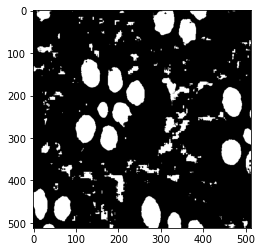

000000_000000_000542_000000_0_2.tif


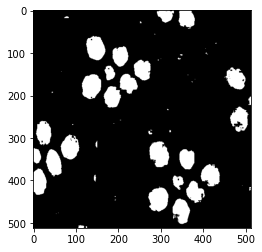

000000_000000_000476_000000_0_1.tif


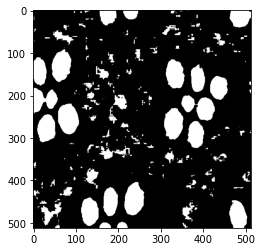

000000_000000_000521_000000_0_1.tif


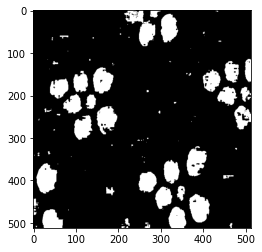

000000_000000_000287_000000_1_0.tif


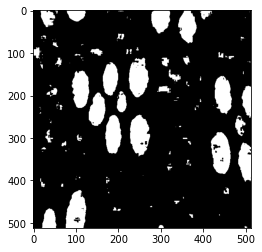

000000_000000_000552_000000_1_0.tif


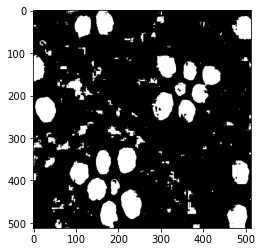

000000_000000_000546_000000_0_0.tif


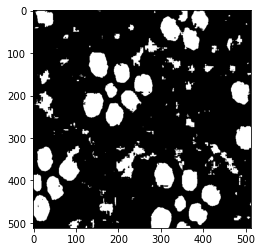

000000_000000_000555_000000_0_0.tif


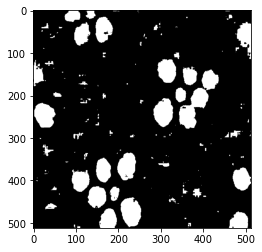

000000_000000_000538_000000_0_1.tif


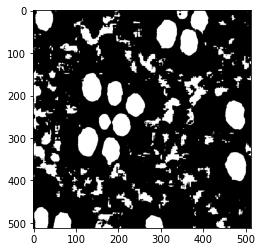

000000_000000_000319_000000_0_2.tif


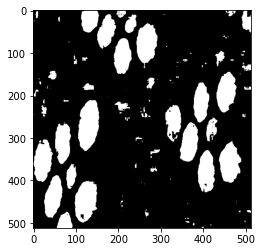

000000_000000_000504_000000_1_0.tif


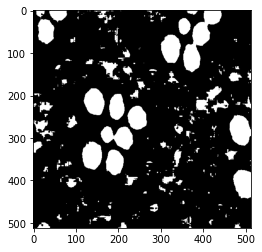

000000_000000_000488_000000_1_0.tif


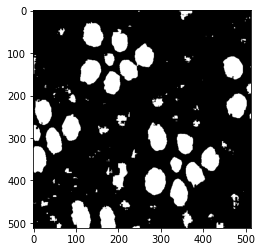

000000_000000_000359_000000_0_0.tif


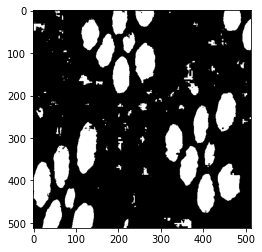

000000_000000_000497_000000_1_0.tif


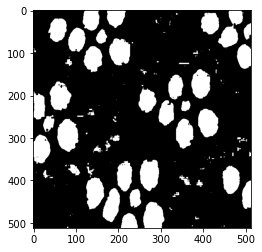

000000_000000_000408_000000_0_0.tif


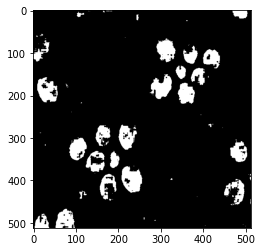

000000_000000_000522_000000_0_0.tif


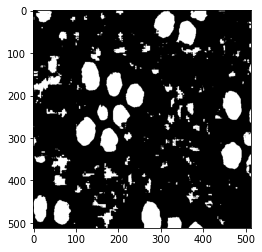

000000_000000_000463_000000_1_1.tif


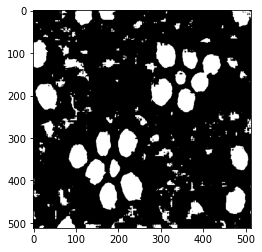

000000_000000_000547_000000_1_1.tif


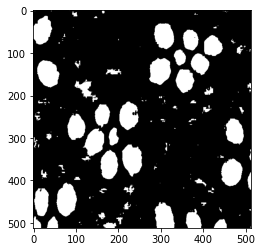

000000_000000_000562_000000_0_0.tif


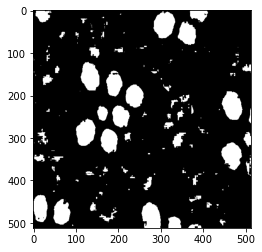

000000_000000_000552_000000_1_2.tif


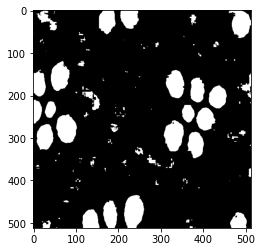

In [65]:
import cv2
from PIL import Image

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train,
                    y_train,
                    batch_size=60,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

# Make predictions and apply thresholding
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.25).astype(np.uint8)
#z_pred = (y_pred > 0.30).astype(np.uint8)
# Calculate precision, recall, and F1 score
#report = classification_report(y_test.flatten(), y_pred.flatten(), target_names=['background', 'circle'], output_dict=True)
#print('Classification report:\n', report)

# Apply contrast stretching to the predicted images
new_min_value = 0
new_max_value = 255

for i in range(20):#for i in range(y_pred.shape[0]):
    z = images_name[i]
    image = Image.fromarray((y_pred[i].squeeze() * 255).astype(np.uint8))
    #image1 = Image.fromarray((z_pred[i].squeeze() * 255).astype(np.uint8))
    min_value, max_value = image.getextrema()
    #mini_value1, maxi_value1 = image1.getextrema()
    scale = (new_max_value - new_min_value) / (max_value - min_value)
   # scale1 = (new_max_value1 - new_min_value1) / (maxi_value1 - mini_value1)
    image = image.point(lambda i: (i - min_value) * scale + new_min_value)
    #image1 = image.point(lambda i: (i - mini_value1) * scale + new_mini_value1)
    y_pred[i] = np.expand_dims(np.array(image), axis=-1) / 255
   # z_pred[i] = np.expand_dims(np.array(image1), axis=-1) / 255
    print(z)
    binary_mask = y_pred[i]
    #binary_mask1 = z_pred[i]
    plt.imshow(binary_mask, cmap='gray')
    plt.show()    
    #processing(binary_mask)
    #pros(binary_mask)
    #plt.imshow(binary_mask, cmap='gray')
    #plt.show()
    #pros(binary_mask1)
# print(z)
# binary_mask = y_pred[i]
# plt.imshow(binary_mask, cmap='gray')
# plt.show()
# #processing(binary_mask)


In [67]:
import cv2
from PIL import Image
def a(thres):
    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    history = model.fit(X_train,
                        y_train,
                        batch_size=60,
                        epochs=50,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping])

    # Make predictions and apply thresholding
    y_pred = model.predict(X_test)
    y_pred = (y_pred > thres).astype(np.uint8)
    #z_pred = (y_pred > 0.30).astype(np.uint8)
    # Calculate precision, recall, and F1 score
    #report = classification_report(y_test.flatten(), y_pred.flatten(), target_names=['background', 'circle'], output_dict=True)
    #print('Classification report:\n', report)

    # Apply contrast stretching to the predicted images
    new_min_value = 0
    new_max_value = 255

    for i in range(20):#for i in range(y_pred.shape[0]):
        z = images_name[i]
        image = Image.fromarray((y_pred[i].squeeze() * 255).astype(np.uint8))
        #image1 = Image.fromarray((z_pred[i].squeeze() * 255).astype(np.uint8))
        min_value, max_value = image.getextrema()
        #mini_value1, maxi_value1 = image1.getextrema()
        scale = (new_max_value - new_min_value) / (max_value - min_value)
       # scale1 = (new_max_value1 - new_min_value1) / (maxi_value1 - mini_value1)
        image = image.point(lambda i: (i - min_value) * scale + new_min_value)
        #image1 = image.point(lambda i: (i - mini_value1) * scale + new_mini_value1)
        y_pred[i] = np.expand_dims(np.array(image), axis=-1) / 255
       # z_pred[i] = np.expand_dims(np.array(image1), axis=-1) / 255
        print(z)
        binary_mask = y_pred[i]
        #binary_mask1 = z_pred[i]
        plt.imshow(binary_mask, cmap='gray')
        plt.show()    
        #processing(binary_mask)
        #pros(binary_mask)
        #plt.imshow(binary_mask, cmap='gray')
        #plt.show()
        #pros(binary_mask1)
    # print(z)
    # binary_mask = y_pred[i]
    # plt.imshow(binary_mask, cmap='gray')
    # plt.show()
    # #processing(binary_mask)


Epoch 1/50
20/20 [==============================] - 11s 532ms/step - loss: 0.1163 - mean_io_u: 0.4444 - val_loss: 0.1168 - val_mean_io_u: 0.4433
Epoch 2/50
20/20 [==============================] - 11s 532ms/step - loss: 0.1170 - mean_io_u: 0.4444 - val_loss: 0.1143 - val_mean_io_u: 0.4433
Epoch 3/50
20/20 [==============================] - 11s 535ms/step - loss: 0.1156 - mean_io_u: 0.4444 - val_loss: 0.1136 - val_mean_io_u: 0.4433
Epoch 4/50
20/20 [==============================] - 11s 538ms/step - loss: 0.1142 - mean_io_u: 0.4444 - val_loss: 0.1138 - val_mean_io_u: 0.4433
Epoch 5/50
20/20 [==============================] - 11s 533ms/step - loss: 0.1163 - mean_io_u: 0.4444 - val_loss: 0.1158 - val_mean_io_u: 0.4433
Epoch 6/50
20/20 [==============================] - 11s 533ms/step - loss: 0.1153 - mean_io_u: 0.4444 - val_loss: 0.1163 - val_mean_io_u: 0.4433
Epoch 7/50
20/20 [==============================] - 11s 534ms/step - loss: 0.1178 - mean_io_u: 0.4444 - val_loss: 0.1191 - val_mea

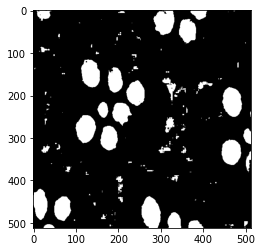

000000_000000_000542_000000_0_2.tif


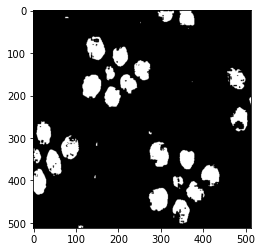

000000_000000_000476_000000_0_1.tif


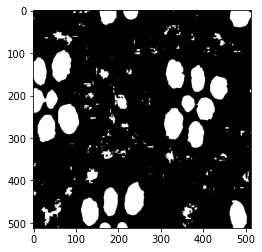

000000_000000_000521_000000_0_1.tif


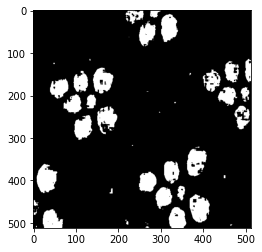

000000_000000_000287_000000_1_0.tif


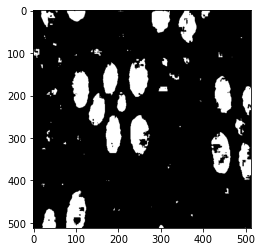

000000_000000_000552_000000_1_0.tif


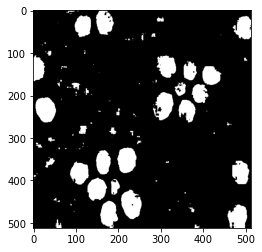

000000_000000_000546_000000_0_0.tif


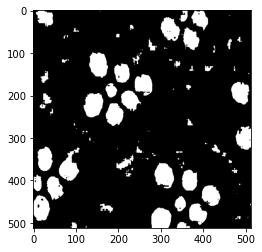

000000_000000_000555_000000_0_0.tif


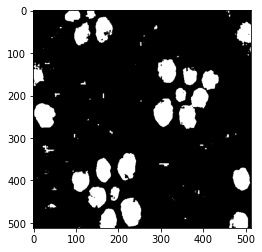

000000_000000_000538_000000_0_1.tif


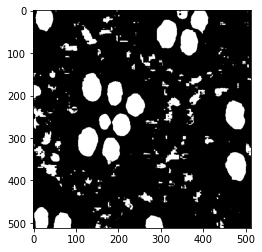

000000_000000_000319_000000_0_2.tif


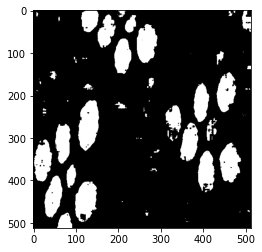

000000_000000_000504_000000_1_0.tif


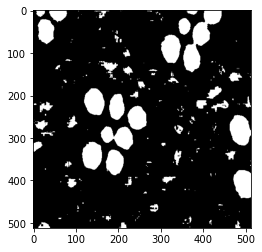

000000_000000_000488_000000_1_0.tif


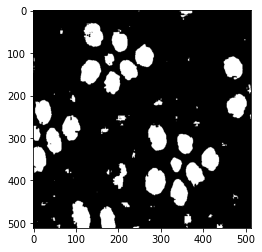

000000_000000_000359_000000_0_0.tif


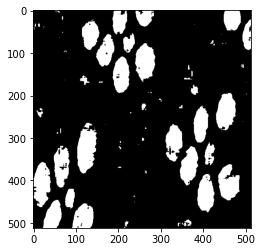

000000_000000_000497_000000_1_0.tif


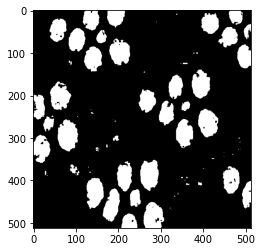

000000_000000_000408_000000_0_0.tif


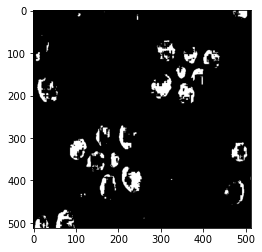

000000_000000_000522_000000_0_0.tif


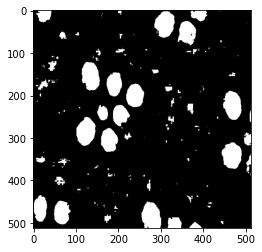

000000_000000_000463_000000_1_1.tif


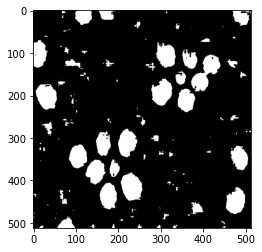

000000_000000_000547_000000_1_1.tif


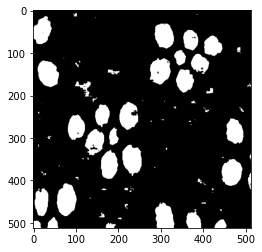

000000_000000_000562_000000_0_0.tif


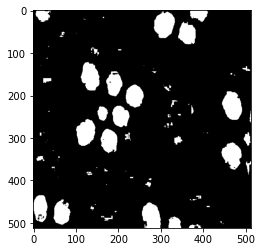

000000_000000_000552_000000_1_2.tif


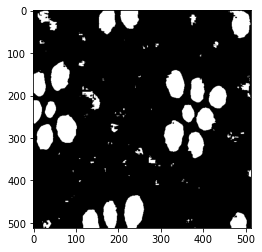

In [69]:
a(0.20)

In [ ]:
a(0.35)

In [62]:
labels(binary_mask)

In [124]:
print(sizes)

TypeError: 'numpy.ndarray' object is not callable

In [1]:
pros(binary_mask)

NameError: name 'pros' is not defined

In [ ]:
##################################################################################################

In [ ]:
def processing(binary_mask):
    labeled, number = mh.label(binary_mask)
    sizes = mh.labeled.labeled_size(labeled)
    print ('sizes:',sizes)
    len(sizes)
    too_small = np.where(sizes < min_region_size)
    labeled_only_big = mh.labeled.remove_regions(labeled, too_small)

    ##############

    binary_mask = labeled_only_big.copy()
    binary_mask[binary_mask > 0] = 1

    print('labelled only big')
    plt.imshow(binary_mask)
    labels(binary_mask)
    #######

    binary_mask_closed = mh.gaussian_filter(binary_mask, sigma=5)
    print('gassuian filter sigma =5')
    plt.imshow(binary_mask_closed)
    labels(binary_mask_closed)

    #######
    binary_mask_open=mh.morph.close_holes(binary_mask)
    plt.imshow(binary_mask_open)
    labels(binary_mask_open)


    ##########
    for i in range(3):
        binary_mask_open = mh.morph.dilate(binary_mask_open)
        print('dilate range of 3')
        plt.imshow(binary_mask_open)
        labels(binary_mask_open)

In [ ]:
def nt_early_pp(batch,epochs,plot,thres):
    import cv2
    from PIL import Image

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    history = model.fit(X_train,
                        y_train,
                        batch_size=batch,
                        epochs=epochs,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping])

    # Make predictions and apply thresholding
    y_pred = model.predict(X_test)
    y_pred = (y_pred > thres).astype(np.uint8)

    # Calculate precision, recall, and F1 score
    #report = classification_report(y_test.flatten(), y_pred.flatten(), target_names=['background', 'circle'], output_dict=True)
    #print('Classification report:\n', report)

    # Apply contrast stretching to the predicted images
    new_min_value = 0
    new_max_value = 255

    for i in range(y_pred.shape[0]):
        z = images_name[i]
        image = Image.fromarray((y_pred[i].squeeze() * 255).astype(np.uint8))
        min_value, max_value = image.getextrema()
        scale = (new_max_value - new_min_value) / (max_value - min_value)
        image = image.point(lambda i: (i - min_value) * scale + new_min_value)
        y_pred[i] = np.expand_dims(np.array(image), axis=-1) / 255
        print(z)
        binary_mask = y_pred[i]
        plt.imshow(binary_mask, cmap='gray')
        plt.show()
        #processing(binary_mask)
        
        #
        
        
        
    # Plotting results
    from keras_unet.utils import plot_segm_history
    # shutil.copy(os.path.join(path1, z), os.path.join(path2, z))
    # save_path = os.path.join(save_dir, image_name[i])
    # print("Saving image to:", save_path)
    # cv2.imwrite(save_path, y_pred)

#     history.history.keys()
#     metrics = list(history.history.keys())
#     plot_segm_history(history, metrics=metrics)   
#     plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=plot)



In [ ]:
labeled, number = mh.label(binary_mask)
    sizes = mh.labeled.labeled_size(labeled)
    #print ('sizes:',sizes)
    a = len(sizes)
    print ('length of sizes =',a)
    too_small = np.where(sizes < min_region_size)
    labeled_only_big = mh.labeled.remove_regions(labeled, too_small)

    ##############

    binary_mask = labeled_only_big.copy()
    binary_mask[binary_mask > 0] = 1

    print('labelled only big')
    plt.imshow(binary_mask)
    labels(binary_mask)
    #######

    binary_mask_closed = mh.gaussian_filter(binary_mask, sigma=5)
    print('gassuian filter sigma =5')
    plt.imshow(binary_mask_closed)
    labels(binary_mask_closed)

    #######
    binary_mask_open=mh.morph.close_holes(binary_mask)
    plt.imshow(binary_mask_open)
    labels(binary_mask_open)


    ##########
    for i in range(3):
        binary_mask_open = mh.morph.dilate(binary_mask_open)
        print('dilate range of 3')
        plt.imshow(binary_mask_open)
        labels(binary_mask_open)

In [ ]:

binary_mask = labeled_only_big.copy()
binary_mask[binary_mask > 0] = 1

#binary_mask = mh.morph.close(binary_mask)
# Plot the binary mask
plt.imshow(binary_mask, cmap='gray')
plt.show()

# Calculate number_1
labeled, num = mh.label(binary_mask)
print("Number_1:", num)

# Calculate region sizes
region_sizes = measure.regionprops(labeled, intensity_image=binary_mask)
sizes = [region.area for region in region_sizes]

# Find min_region_size
sizes.sort()
large_region_start_index = next((i for i in range(1,len(sizes)) if sizes[i] - sizes[i-1] > 100), len(sizes))
min_region_size = (sizes[large_region_start_index-1] + sizes[large_region_start_index]) // 2
print("Min_region_size:", min_region_size)

# Calculate large_regions
num_large_regions = 0
for region in region_sizes:
    if region.area > min_region_size:
        num_large_regions += 1
print("Large_regions:", num_large_regions)

# Calculate threshold
thresh = filters.threshold_otsu(binary_mask)
print("Threshold:", thresh)

In [ ]:
######################### POST PROCESSING###############

In [ ]:
import cv2
import numpy as np

# Load the binary image
image = cv2.imread('image.png', 0)

# Find the contours in the image
contours, _ = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# Calculate the sizes and thicknesses of the contours
sizes = []
thicknesses = []
for contour in contours:
    size = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    thickness = 4 * np.pi * size / (perimeter ** 2)
    sizes.append(size)
    thicknesses.append(thickness)

# Calculate the mean and standard deviation of the sizes and thicknesses
mean_size = np.mean(sizes)
std_size = np.std(sizes)
mean_thickness = np.mean(thicknesses)
std_thickness = np.std(thicknesses)

# Set the minimum size and thickness for the contours
min_size = mean_size - std_size
min_thickness = mean_thickness - std_thickness

# Calculate the distances between the contours
distances = []
for contour1 in contours:
    for contour2 in contours:
        if contour1 is not contour2:
            dist = cv2.pointPolygonTest(contour1, tuple(contour2[0][0]), True)
            distances.append(abs(dist))

# Calculate the median of the distances
median_distance = np.median(distances)

# Set the distance threshold for the pointPolygonTest function
distance_threshold = median_distance

# Create a mask to store the filtered contours
mask = np.zeros_like(image)

# Iterate through the contours
for contour in contours:
    # Calculate the size and thickness of the contour
    size = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    thickness = 4 * np.pi * size / (perimeter ** 2)

    # Check if the contour is close to any larger regions
    close_to_larger_region = False
    for other_contour in contours:
        if cv2.contourArea(other_contour) > size:
            dist = cv2.pointPolygonTest(other_contour, tuple(contour[0][0]), True)
            if abs(dist) < distance_threshold:
                close_to_larger_region = True
                break

    # If the contour is large enough or close to a larger region or thick enough, add it to the mask
    if size > min_size or close_to_larger_region or thickness > min_thickness:
        cv2.drawContours(mask, [contour], -1, 255, -1)

# Apply the mask to the image to remove the small white dots
result = cv2.bitwise_and(image, mask)

# Show the result
cv2.imshow('Result', result)
cv2.waitKey(0)